# Deep Learning Midterm Project
>[ 專案題目 ]： “Transfer Learning for Pneumonia Detection by Chest X-Ray Images” <br>
[ 專案內容 ]： 透過兩種 Transfer Learning 方式：Feature Extraction & Fine-Tuning，分別建立以 'pneumonia-detection.zip'(Pneumonia-Detection dataset, Ref. 1 & 2) 資料集的預測模型。 <br>
(1) 首先輸入 Pneumonia Detection 胸腔 X 光影像資料集，將其標籤為三類，如下： <br>
Normal (正常)、Bacterial (細菌感染)、Viral (病毒感染) <br>
(2) 利用 Keras Applications: ResNet152V2 建立多元分類模型 (三類)，並輸出結果。 <br>
(3) 之後，請從 Keras Applications: Inceptionv3 and MobileNetV2 (Ref. 3) 二者 <br>
中，選擇一個 Pre-trained Model 建立多元分類模型 (三類)，並輸出結果。 <br>
(4) 比較上述 (1) & (2) 的模型與結果：並做出結論 (Conclusion)。 <br>
(5) < 建議 > : 上述的多元分類模型 請調校至 Test_ Accuracy 大於 95%！ <br>
--------------------------------------------
[ REFERENCE ]:
1. 'pneumonia-detection.zip' (Pneumonia-Detection dataset) :
https://drive.google.com/file/d/1hRm-TYrHXh4-iwITwHkCoPEqmdNLJH-n/view?usp=sharing
[ NOTE ]: Kaggle Dataset - “Chest X-Ray Images (Pneumonia)”
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
2. Kaggle InClass - “Pneumonia Detection by Chest X-Ray Images”,
https://www.kaggle.com/competitions/pneumonia-detection
3. Keras Applications : https://keras.io/api/applications/

In [1]:
import tensorflow as tf

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix

import cv2
import os
import glob

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

##  Go to this URL in a browser: https://accounts.google.com/o/oauth2/......
##  Enter your authorization code:
##   ··········
##  Mounted at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/Colab Notebooks/chest_xray"
##  Loading CIFAR-10 dataset from your Google Drive
INPUT_PATH = "/content/drive/My Drive/Colab Notebooks/chest_xray"

test  train  val


In [5]:
# list of all the training images
train_normal = Path(INPUT_PATH + '/train/NORMAL').glob('*.jpeg')
train_pneumonia = Path(INPUT_PATH + '/train/PNEUMONIA').glob('*.jpeg')
# put on label
normal_data = [(image, 0) for image in train_normal]
bacteria_data =[]; virus_data = [];
for image in train_pneumonia:
    if 'bacteria' in os.path.basename(image):
        bacteria_data.append((image,1))
    else:
        virus_data.append((image,2))

train_data = normal_data + bacteria_data + virus_data

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'])

train_data.head()

,image,label
0,/content/drive/My Drive/Colab Notebooks/chest_...,0
1,/content/drive/My Drive/Colab Notebooks/chest_...,0
2,/content/drive/My Drive/Colab Notebooks/chest_...,0
3,/content/drive/My Drive/Colab Notebooks/chest_...,0
4,/content/drive/My Drive/Colab Notebooks/chest_...,0


In [6]:
#shuffle the data
train_data = train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
train_data.head(10)

,image,label
0,/content/drive/My Drive/Colab Notebooks/chest_...,1
1,/content/drive/My Drive/Colab Notebooks/chest_...,1
2,/content/drive/My Drive/Colab Notebooks/chest_...,2
3,/content/drive/My Drive/Colab Notebooks/chest_...,2
4,/content/drive/My Drive/Colab Notebooks/chest_...,1
5,/content/drive/My Drive/Colab Notebooks/chest_...,2
6,/content/drive/My Drive/Colab Notebooks/chest_...,0
7,/content/drive/My Drive/Colab Notebooks/chest_...,2
8,/content/drive/My Drive/Colab Notebooks/chest_...,2
9,/content/drive/My Drive/Colab Notebooks/chest_...,1


In [7]:
print(train_data)

                                                  image  label
0     /content/drive/My Drive/Colab Notebooks/chest_...      1
1     /content/drive/My Drive/Colab Notebooks/chest_...      1
2     /content/drive/My Drive/Colab Notebooks/chest_...      2
3     /content/drive/My Drive/Colab Notebooks/chest_...      2
4     /content/drive/My Drive/Colab Notebooks/chest_...      1
...                                                 ...    ...
5212  /content/drive/My Drive/Colab Notebooks/chest_...      2
5213  /content/drive/My Drive/Colab Notebooks/chest_...      1
5214  /content/drive/My Drive/Colab Notebooks/chest_...      0
5215  /content/drive/My Drive/Colab Notebooks/chest_...      0
5216  /content/drive/My Drive/Colab Notebooks/chest_...      2

[5217 rows x 2 columns]


Total of Train Data :  5217   (0 : Normal; 1 : Bacteria; 2 : Virus)
1    2530
2    1346
0    1341
Name: label, dtype: int64


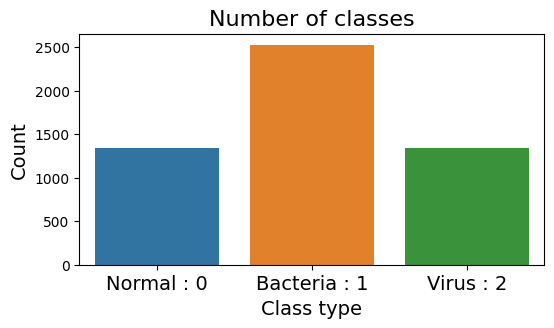

In [8]:
count_result = train_data['label'].value_counts()
print('Total of Train Data : ', len(train_data), '  (0 : Normal; 1 : Bacteria; 2 : Virus)')
print(count_result)

# Plot the results
plt.figure(figsize=(6,3))
sns.countplot(x = 'label', data =  train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Normal : 0', 'Bacteria : 1', 'Virus : 2'],
           fontsize=14)
plt.show()

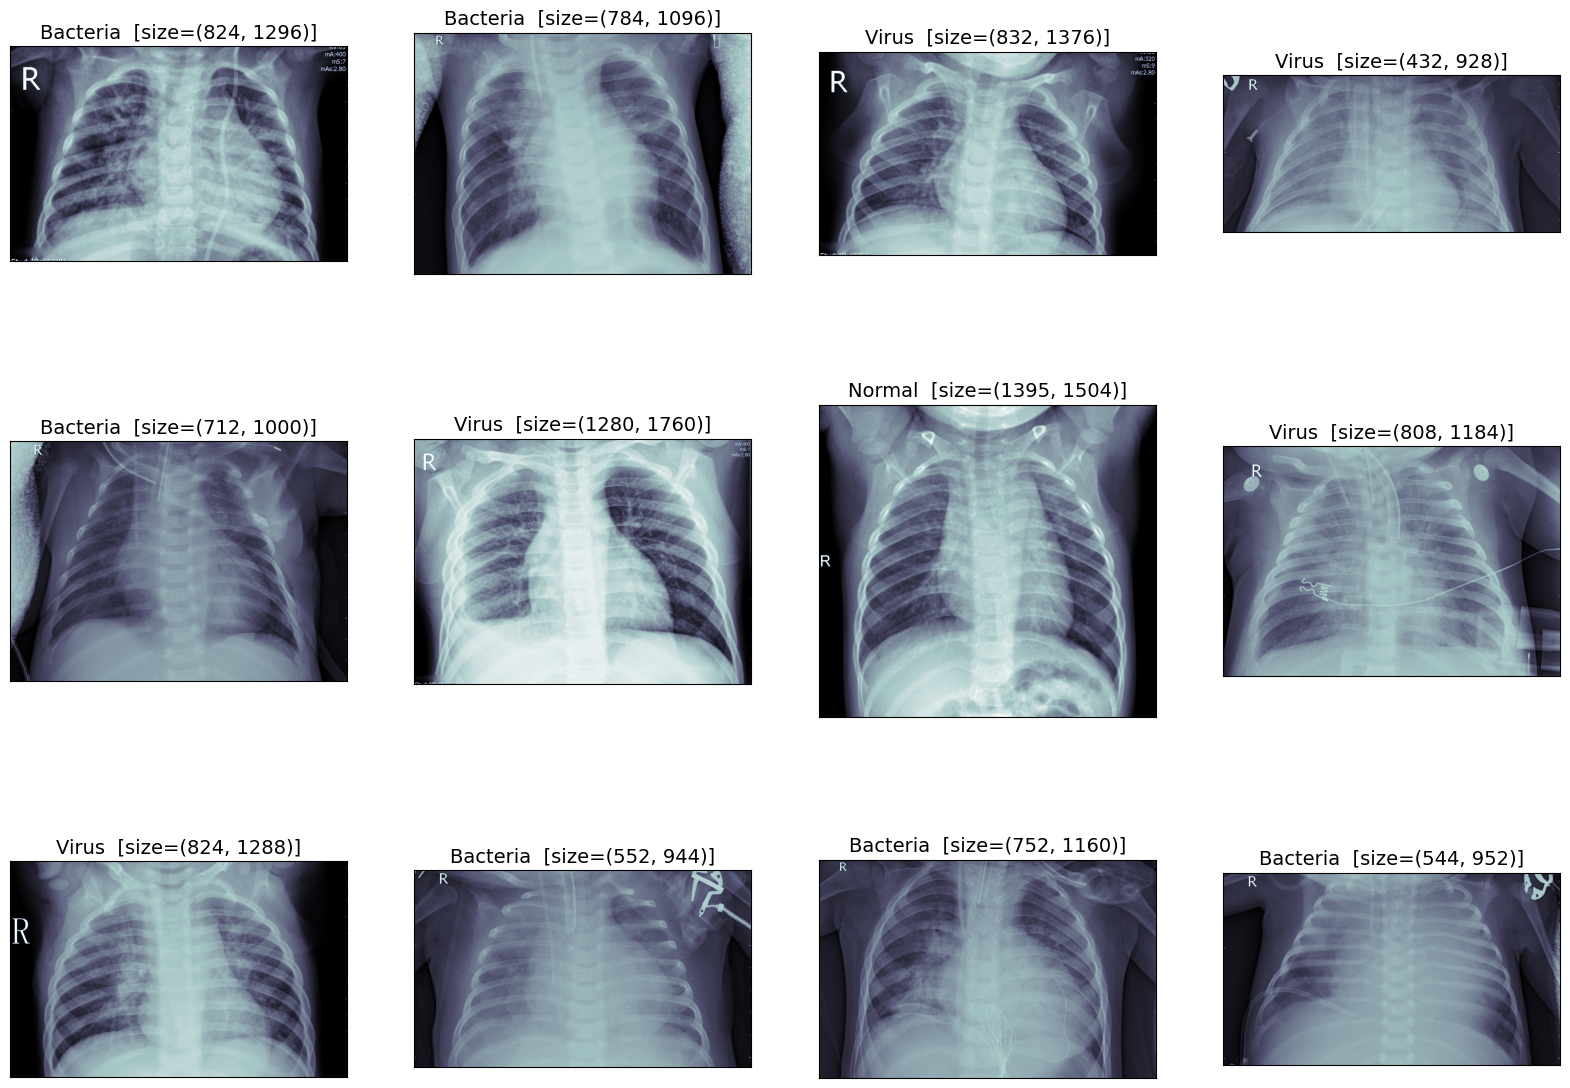

In [9]:
fig, ax = plt.subplots(3, 4, figsize=(20,15))
title = ['Normal', 'Bacteria', 'Virus']
for i, axi in enumerate(ax.flat):
    image = imread(train_data.image[i])
    axi.imshow(image, cmap='bone')
    axi.set_title( title[train_data.label[i]]
                  + '  [size=' + str(image.shape) +']',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])

In [10]:
train_data.to_numpy().shape

(5217, 2)

In [9]:
def load_data(files_dir='/train'):
    # list of the paths of all the image files
    normal = Path(INPUT_PATH + files_dir + '/NORMAL').glob('*.jpeg')
    pneumonia = Path(INPUT_PATH + files_dir + '/PNEUMONIA').glob('*.jpeg')

    normal_data = [(image, 0) for image in normal]
    bacteria_data =[]; virus_data = [];
    for image in pneumonia:
        if 'bacteria' in os.path.basename(image):
            bacteria_data.append((image,1))
        else:
            virus_data.append((image,2))

    image_data = normal_data + bacteria_data + virus_data

    # Get a pandas dataframe for the data paths
    image_data = pd.DataFrame(image_data, columns=['image', 'label'])

    # Shuffle the data
    image_data = image_data.sample(frac=1., random_state=100).reset_index(drop=True)

    # Importing both image & label datasets...
    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))],
                         [image_data.iloc[i][1] for i in range(len(image_data))])

    # Convert the list into numpy arrays
    x_images = np.array(x_images)
    y_labels = np.array(y_labels)

    print("Total number of images: ", x_images.shape)
    print("Total number of labels: ", y_labels.shape)

    return x_images, y_labels

In [10]:
# ---------------------------------------------------------
#  1. Resizing all the images to 224x224 with 3 channels.
#  2. Then, normalize the pixel values.
# ---------------------------------------------------------
def data_input(dataset):
    # print(dataset.shape)
    for image_file in dataset:
        image = cv2.imread(str(image_file))
        image = cv2.resize(image, (224,224))
        if image.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise
            #              (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            image = np.dstack([image, image, image])

        # ----------------------------------------------------------
        # cv2.cvtColor(): The function converts an input image
        #                 from one color space to another.
        # [Ref.1]: "cvtColor - OpenCV Documentation"
        #     - https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html
        # [Ref.2]: "Python计算机视觉编程- 第十章 OpenCV"
        #     - https://yongyuan.name/pcvwithpython/chapter10.html
        # ----------------------------------------------------------
        x_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

Import Training Datasets

In [11]:
x_train, y_train = load_data(files_dir='/train')

print(x_train.shape)
print(y_train.shape)

Total number of images:  (5217, 224, 224, 3)
Total number of labels:  (5217,)
(5217, 224, 224, 3)
(5217,)


In [12]:
print(x_train[0].shape)
x_train[0]

(224, 224, 3)


array([[[0.04313726, 0.04313726, 0.04313726],
        [0.05098039, 0.05098039, 0.05098039],
        [0.06666667, 0.06666667, 0.06666667],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.49803922, 0.49803922, 0.49803922],
        [0.18039216, 0.18039216, 0.18039216]],

       [[0.05098039, 0.05098039, 0.05098039],
        [0.04313726, 0.04313726, 0.04313726],
        [0.07058824, 0.07058824, 0.07058824],
        ...,
        [0.11764706, 0.11764706, 0.11764706],
        [0.80784315, 0.80784315, 0.80784315],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.05490196, 0.05490196, 0.05490196],
        [0.05882353, 0.05882353, 0.05882353],
        [0.07058824, 0.07058824, 0.07058824],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.9647059 , 0.9647059 , 0.9647059 ],
        [0.05490196, 0.05490196, 0.05490196]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [13]:
y_train

array([1, 1, 2, ..., 0, 0, 2])

Import Validation Datasets

In [14]:
# Import validation dataset...
x_val, y_val = load_data(files_dir='/val')

print(x_val.shape)
print(y_val.shape)

Total number of images:  (16, 224, 224, 3)
Total number of labels:  (16,)
(16, 224, 224, 3)
(16,)


In [15]:
x_val[0]

array([[[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.05490196, 0.05490196, 0.05490196],
        [0.05098039, 0.05098039, 0.05098039],
        [0.03137255, 0.03137255, 0.03137255]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.05098039, 0.05098039, 0.05098039],
        [0.03529412, 0.03529412, 0.03529412],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314],
        ...,
        [0.04313726, 0.04313726, 0.04313726],
        [0.02745098, 0.02745098, 0.02745098],
        [0.00392157, 0.00392157, 0.00392157]],

       ...,

       [[0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0.02745098, 0.02745098],
        [0.02745098, 0

In [16]:
y_val

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1])

Import Testing Datasets

In [17]:
# Import test dataset...
x_test, y_test = load_data(files_dir='/test')

print(x_test.shape)
print(y_test.shape)

Total number of images:  (624, 224, 224, 3)
Total number of labels:  (624,)
(624, 224, 224, 3)
(624,)


In [18]:
# Counts for both classes
count_result = pd.Series(y_test).value_counts()
print('Total of Test Data : ', len(y_test), '  (0 : Normal; 1 : Bacteria; 2 : Virus)')
print('------------------')
print(count_result)
print('------------------')
print('2 :  ', count_result[2]/sum(count_result))
print('1 :  ', count_result[1]/sum(count_result))
print('0 :  ', count_result[0]/sum(count_result))

Total of Test Data :  624   (0 : Normal; 1 : Bacteria; 2 : Virus)
------------------
1    242
0    234
2    148
dtype: int64
------------------
2 :   0.23717948717948717
1 :   0.38782051282051283
0 :   0.375


In [19]:
y_test[:10]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

TNN Model by tf.keras(ResNet152V2)

In [20]:
base_model_1 = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights='imagenet')

234545216/234545216 [==============================] - 11s 0us/step


In [21]:
base_model_1.trainable = False

In [28]:
base_model_1.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model_1(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256,kernel_regularizer=regularizers.l2(0.001), activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                                                             

Train the Model

In [25]:
initial_epochs = 50
history = model.fit(x_train,y_train,epochs=initial_epochs,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/50
82/82 [==============================] - 64s 498ms/step - loss: 1.5249 - accuracy: 0.6603 - val_loss: 1.9492 - val_accuracy: 0.4375
Epoch 2/50
82/82 [==============================] - 36s 438ms/step - loss: 1.2666 - accuracy: 0.7353 - val_loss: 1.7208 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 35s 433ms/step - loss: 1.1541 - accuracy: 0.7592 - val_loss: 1.4769 - val_accuracy: 0.5625
Epoch 4/50
82/82 [==============================] - 36s 437ms/step - loss: 1.0666 - accuracy: 0.7759 - val_loss: 1.7554 - val_accuracy: 0.4375
Epoch 5/50
82/82 [==============================] - 36s 434ms/step - loss: 1.0252 - accuracy: 0.7707 - val_loss: 1.5378 - val_accuracy: 0.5625
Epoch 6/50
82/82 [==============================] - 36s 436ms/step - loss: 0.9853 - accuracy: 0.7803 - val_loss: 1.3252 - val_accuracy: 0.5625
Epoch 7/50
82/82 [==============================] - 36s 436ms/step - loss: 0.9403 - accuracy: 0.7801 - val_loss: 1.1538 - val_accuracy: 0.5625

Learning Curves

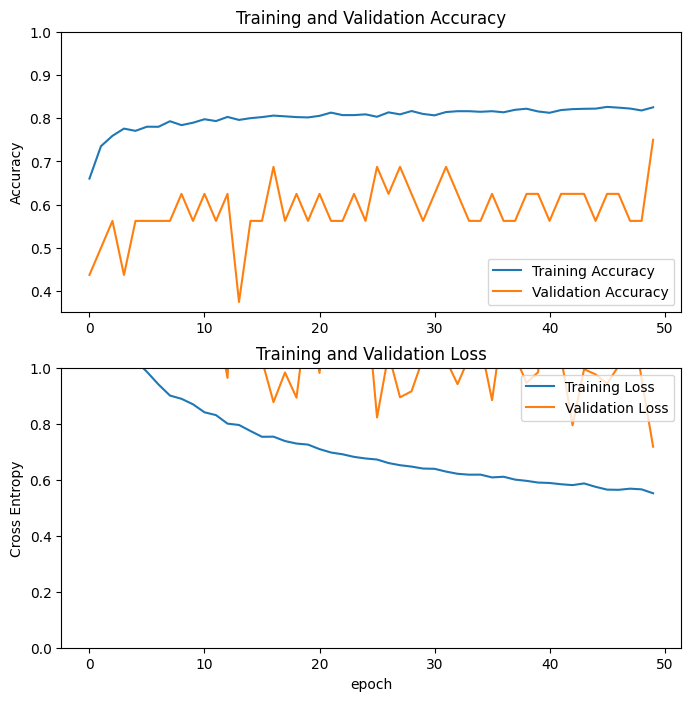

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
# Score trained model.
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

20/20 [==============================] - 6s 223ms/step - loss: 0.7362 - accuracy: 0.8253
Test loss: 0.7362163066864014
Test accuracy: 0.8253205418586731


Fine Tuning

In [ ]:
base_model_1.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_1.layers))

# Fine-tune from this layer onwards
fine_tune_at = 555

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_1.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  564


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train,y_train,epochs=total_epochs,initial_epoch=history.epoch[-1],validation_data=(x_val,y_val))

TNN Model by tf.keras(MobileNetV2)

In [21]:
base_model_2 = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [22]:
base_model_2.trainable = False

In [ ]:
base_model_2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [23]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3)

In [24]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model_2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
initial_epochs = 50
history1 = model.fit(x_train,y_train,epochs=initial_epochs,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/50
82/82 [==============================] - 25s 117ms/step - loss: 1.2606 - accuracy: 0.6164 - val_loss: 1.0072 - val_accuracy: 0.8125
Epoch 2/50
82/82 [==============================] - 8s 98ms/step - loss: 1.0335 - accuracy: 0.7232 - val_loss: 1.0725 - val_accuracy: 0.6875
Epoch 3/50
82/82 [==============================] - 8s 92ms/step - loss: 0.9672 - accuracy: 0.7464 - val_loss: 0.9842 - val_accuracy: 0.6875
Epoch 4/50
82/82 [==============================] - 8s 98ms/step - loss: 0.9217 - accuracy: 0.7558 - val_loss: 1.0554 - val_accuracy: 0.6875
Epoch 5/50
82/82 [==============================] - 8s 94ms/step - loss: 0.8880 - accuracy: 0.7623 - val_loss: 1.0238 - val_accuracy: 0.6875
Epoch 6/50
82/82 [==============================] - 8s 98ms/step - loss: 0.8646 - accuracy: 0.7694 - val_loss: 1.2923 - val_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 8s 93ms/step - loss: 0.8494 - accuracy: 0.7688 - val_loss: 1.0323 - val_accuracy: 0.6250
Epoch 8/50


Learning Curve

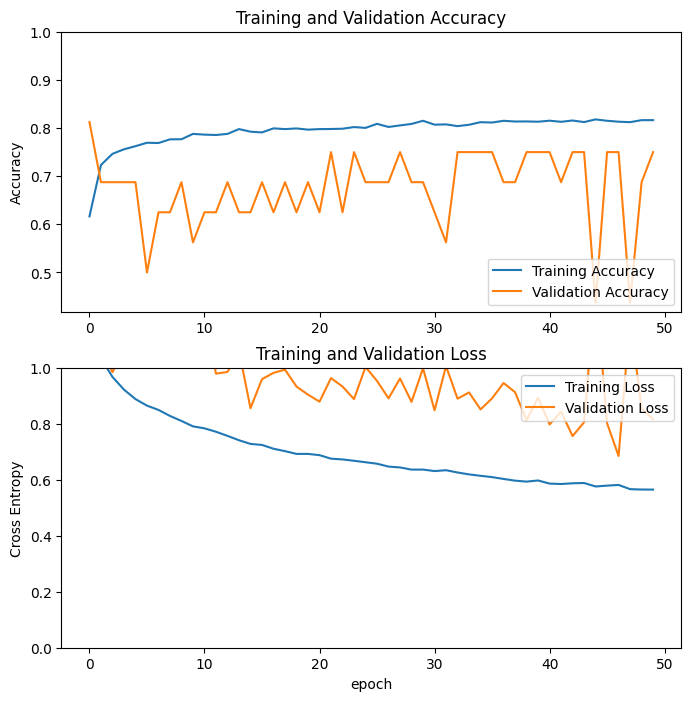

In [27]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# Score trained model.
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

20/20 [==============================] - 2s 46ms/step - loss: 0.6813 - accuracy: 0.8285
Test loss: 0.6813439726829529
Test accuracy: 0.8285256624221802


Fine-tuning

In [29]:
base_model_2.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 148

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(x_train,y_train,epochs=total_epochs,initial_epoch=history1.epoch[-1],validation_data=(x_val,y_val))

在此期中報告中，出現事前完全沒意料到會發生的狀況，就是google colab雲端的儲存空間不夠，導致程式跑到一半就會自動中斷，限制了模型的自由度(無法Fine-tuning)與準確度，目前還沒想到解決辦法。但若在時間以及環境允許的情況下，我有信心可以把test accuracy提升到85%以上，第一個改善的方法是增加訓練的次數;第二是在fine tuning中開放更多可調教參數的層數。就現有的研究結果評斷兩pre-trained model的績效，會是MobileNetV2更勝一籌!